# Situación problema 

Se desea realizar un modelo de Forecast con cualquier técnica de su preferencia para pronosticar las ventas para los siguientes 7 días desde el final del histórico de datos, tenga en cuenta que la fecha de la venta se encuentra en la variable “saletime” y que esta está mostrada a una granularidad de factura individual.

# Exploración del dataset dado

Se importa cada una de las tablas de la base de datos dada, para visualizar los datos y extraer solo los necesarios para la resolución del problema.

# Librerias 

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
%matplotlib inline
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
from plotly.subplots import make_subplots
import seaborn as sn
pio.renderers.default = "notebook_connected"
from statsmodels.graphics.tsaplots import plot_acf
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from joblib import dump, load
from keras.models import Sequential
from keras.layers import LSTM
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings('ignore')

## Visualización de los datos dados

### Las tablas proporcionadas fueron: 

In [2]:
#tabla eventos
allevents = "dataset/allevents_pipe.txt"

events = pd.read_csv(allevents,sep='|', header = None ,encoding= 'utf-8')
events .columns = ['eventid','venueid', 'catid', 'dateid', 'eventname','starttime']
events.head()


,eventid,venueid,catid,dateid,eventname,starttime
0,1,305,8,1851,Gotterdammerung,2008-01-25 14:30:00
1,2,306,8,2114,Boris Godunov,2008-10-15 20:00:00
2,3,302,8,1935,Salome,2008-04-19 14:30:00
3,4,309,8,2090,La Cenerentola (Cinderella),2008-09-21 14:30:00
4,5,302,8,1982,Il Trovatore,2008-06-05 19:00:00


In [3]:
#tabla venue
venue = "dataset/venue_pipe.txt"
venues = pd.read_csv(venue,sep='|', header = None ,encoding= 'utf-8')
venues.columns = ['venueid','venuename', 'venuecity', 'venuestate','venueseats']
venues.head()

,venueid,venuename,venuecity,venuestate,venueseats
0,1,Toyota Park,Bridgeview,IL,0
1,2,Columbus Crew Stadium,Columbus,OH,0
2,3,RFK Stadium,Washington,DC,0
3,4,CommunityAmerica Ballpark,Kansas City,KS,0
4,5,Gillette Stadium,Foxborough,MA,68756


In [4]:
#Tabla Categoria
category = "dataset/category_pipe.txt"
categorys = pd.read_csv(category,sep='|', header = None ,encoding= 'utf-8')
categorys.columns =['catid','catgroup','catname','catdesc']
categorys.head()

,catid,catgroup,catname,catdesc
0,1,Sports,MLB,Major League Baseball
1,2,Sports,NHL,National Hockey League
2,3,Sports,NFL,National Football League
3,4,Sports,NBA,National Basketball Association
4,5,Sports,MLS,Major League Soccer


In [5]:
#Tabla Ventas - sales
sale = "dataset/sales_tab.txt"
sales = pd.read_csv(sale,sep='\t', header = None ,encoding= 'utf-8')
sales.columns =['salesid','listid','sellerid','buyerid','eventid','dateid','qtysold','pricepaid','commission','saletime']
sales.head()

,salesid,listid,sellerid,buyerid,eventid,dateid,qtysold,pricepaid,commission,saletime
0,1,1,36861,21191,7872,1875,4,728,109.20,2/18/2008 02:36:48
1,2,4,8117,11498,4337,1983,2,76,11.40,6/6/2008 05:00:16
2,3,5,1616,17433,8647,1983,2,350,52.50,6/6/2008 08:26:17
3,4,5,1616,19715,8647,1986,1,175,26.25,6/9/2008 08:38:52
4,5,6,47402,14115,8240,2069,2,154,23.10,8/31/2008 09:17:02


In [6]:
#Tabla Fechas
date = "dataset/date2008_pipe.txt"
dates = pd.read_csv(date,sep='|', header = None ,encoding= 'utf-8')
dates.columns = ['dateid', 'caldate', 'day', 'week', 'month', 'qtr', 'year','holiday']
dates.head()


,dateid,caldate,day,week,month,qtr,year,holiday
0,1827,2008-01-01,WE,1,JAN,1,2008,True
1,1828,2008-01-02,TH,1,JAN,1,2008,False
2,1829,2008-01-03,FR,1,JAN,1,2008,False
3,1830,2008-01-04,SA,2,JAN,1,2008,False
4,1831,2008-01-05,SU,2,JAN,1,2008,False


In [7]:
#Tabla Lista
listing = "dataset/listings_pipe.txt"
listings = pd.read_csv(listing,sep='|', header = None ,encoding= 'utf-8')
listings.columns = ['listid', 'sellerid', 'eventid', 'dateid', 'numtickets', 'priceperticket', 'totalprice','listtime']
listings.head()

,listid,sellerid,eventid,dateid,numtickets,priceperticket,totalprice,listtime
0,1,36861,7872,1850,10,182.0,1820.0,2008-01-24 06:43:29
1,2,16002,4806,1890,7,233.0,1631.0,2008-03-05 12:25:29
2,3,21461,4256,2131,2,182.0,364.0,2008-11-01 07:35:33
3,4,8117,4337,1970,8,38.0,304.0,2008-05-24 01:18:37
4,5,1616,8647,1963,4,175.0,700.0,2008-05-17 02:29:11


In [8]:
#Tabla Usuarios
user = "dataset/allusers_pipe.txt"
users = pd.read_csv(user,sep='|', header = None ,encoding= 'utf-8')
users.columns = ['userid', 'username', 'firstname', 'lastname', 'city', 'state', 'email','phone','likesports','liketheatre',
'likeconcerts', 'likejazz', 'likeclassical', 'likeopera', 'likerock', 'likevegas', 'likebroadway', 'likemusicals']

users = users[['userid','username', 'firstname', 'lastname', 'city', 'state', 'email',
       'phone', 'likesports', 'liketheatre', 'likeconcerts', 'likejazz',
       'likeclassical', 'likeopera', 'likerock', 'likevegas', 'likebroadway',
       'likemusicals']]
users.head()

,userid,username,firstname,lastname,city,state,email,phone,likesports,liketheatre,likeconcerts,likejazz,likeclassical,likeopera,likerock,likevegas,likebroadway,likemusicals
0,1,JSG99FHE,Rafael,Taylor,Kent,WA,Etiam.laoreet.libero@sodalesMaurisblandit.edu,(664) 602-4412,True,True,NaN,False,True,NaN,NaN,True,False,True
1,2,PGL08LJI,Vladimir,Humphrey,Murfreesboro,SK,Suspendisse.tristique@nonnisiAenean.edu,(783) 492-1886,NaN,NaN,NaN,True,True,NaN,NaN,True,False,True
2,3,IFT66TXU,Lars,Ratliff,High Point,ME,amet.faucibus.ut@condimentumegetvolutpat.ca,(624) 767-2465,True,False,NaN,False,NaN,False,True,NaN,NaN,True
3,4,XDZ38RDD,Barry,Roy,Omaha,AB,sed@lacusUtnec.ca,(355) 452-8168,False,True,NaN,False,NaN,NaN,NaN,NaN,NaN,False
4,5,AEB55QTM,Reagan,Hodge,Forest Lake,NS,Cum@accumsan.com,(476) 519-9131,NaN,NaN,True,False,NaN,NaN,True,True,False,True


## Objetivo problema
Pronosticar las ventas para los siguientes 7 días desde el final del histórico de datos.

Teniendo en cuenta el objetivo del problema:

## La tabla de interés es: 
Tabla Sales

## Las variables de interés son: 

* qtysold: Corresponde al número de boletos que se vendieron.
* saletime: Corresponde a la fecha y hora en que se completó la venta.


In [9]:
data = sales[['qtysold', 'saletime']]
data.head()

,qtysold,saletime
0,4,2/18/2008 02:36:48
1,2,6/6/2008 05:00:16
2,2,6/6/2008 08:26:17
3,1,6/9/2008 08:38:52
4,2,8/31/2008 09:17:02


## Análisis exploratorio
    
1. Cantidad total de columnas y filas que contiene el dataset.
2. Cantidad de valores no-nulos (para reconocer los daots que contienen verdadera información).
3. Los dtypes de cada columna.


In [10]:
# Dimensiones del dataset
print(f'Filas: {data.shape[0]} ,', f'Columnas: {data.shape[1]}')

Filas: 172456 , Columnas: 2


In [11]:
#valores no nulos
#dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172456 entries, 0 to 172455
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   qtysold   172456 non-null  int64 
 1   saletime  172456 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


In [12]:
# Adecuación del formato del dato
data['saletime'] = pd.to_datetime(data['saletime'], infer_datetime_format=True)
data['saletime'] = data['saletime'].dt.strftime('%Y-%m-%d')

In [13]:
# data['saletime'] = data['saletime'].astype('datetime64')
data = data.set_index('saletime')
data = data.sort_index()
data.dtypes

qtysold    int64
dtype: object

In [14]:
print("Fecha inicial dataset:",data.index.min())
print("Fecha Final dataset:",data.index.max())

Fecha inicial dataset: 2008-01-01
Fecha Final dataset: 2008-12-31


Entonces, las ventas van del 01 de enero de 2008 hasta el 31 de diciembre de 2008.

In [15]:
# Descripción de datos
data.describe()

,qtysold
count,172456.000000
mean,2.002534
std,1.068628
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,8.000000


Información hallada es la siguiente:

1. Cantidad de registros: 172456 
2. Media de ventas de boletas: 2
3. Desvío: 1 (se esta entre 1 y 3 posibles ventas de boletas)

In [16]:
data.index
data.index = pd.to_datetime(data.index, infer_datetime_format=True)


In [17]:
# Ventas Diarias
diario = data.resample('D').sum()
diario

,qtysold
saletime,
2008-01-01,19
2008-01-02,57
2008-01-03,94
2008-01-04,157
2008-01-05,210
...,...
2008-12-27,170
2008-12-28,145
2008-12-29,143


In [18]:
# Ventas Mensuales
mensual = data.resample('M').sum()
mensual

,qtysold
saletime,
2008-01-31,15306
2008-02-29,28528
2008-03-31,32840
2008-04-30,30827
2008-05-31,32291
2008-06-30,31361
2008-07-31,33011
2008-08-31,32824
2008-09-30,32240


**Verificación de la serie temporal completa**

In [19]:

fig1 = px.line(diario, x=diario.index, y='qtysold',
              title='Ventas Diarias', markers=True)
fig1.update_xaxes(
    dtick="M1",
    tickformat="%d-%b\n%Y")

fig2 = px.line(mensual, x=mensual.index, y='qtysold',
              title='Ventas Mensuales', markers=True)
fig2.update_xaxes(
    dtick="M1",
    tickformat="%d-%b\n%Y")

    
fig1.show()
fig2.show()

In [20]:
class PlotTimeSeries:
    @staticmethod
    def auto_corr(df, y, lags=1):
        plot = MatplotlinInterface        
        plot.auto_corr(df, y, lags)

    @staticmethod
    def descomponer_ts(df, x, y, modelo='additive', periodo=1):
        plot = MatplotlinInterface
        plot.descomponer_ts(df, x, y, modelo, periodo)

class MatplotlinInterface: 
    @staticmethod
    def auto_corr(df, x, lags=1):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        plot_acf(df[x], lags=lags, ax=ax1)
        plot_pacf(df[x], lags=lags, ax=ax2)
        plt.show()
    @staticmethod
    def descomponer_ts(df, x, y, modelo='additive', periodo=1):
        series = df.loc[:, [x, y]].set_index(x)
        res = seasonal_decompose(series, model = modelo, period = periodo)
        plt.style.use('ggplot')
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,8), sharex=True)
        res.observed.plot(ax=ax1, label='Serie de tiempo', color='blue')
        res.trend.plot(ax=ax2, label='Tendencia', color='green')
        res.seasonal.plot(ax=ax3, label='Estacionalidad', color='purple')
        res.resid.plot(ax=ax4, label='Residuo', color='red')
        for ax in [ax1, ax2, ax3, ax4]:
            ax.legend(loc='upper right', prop={'size': '12'})
        plt.show()

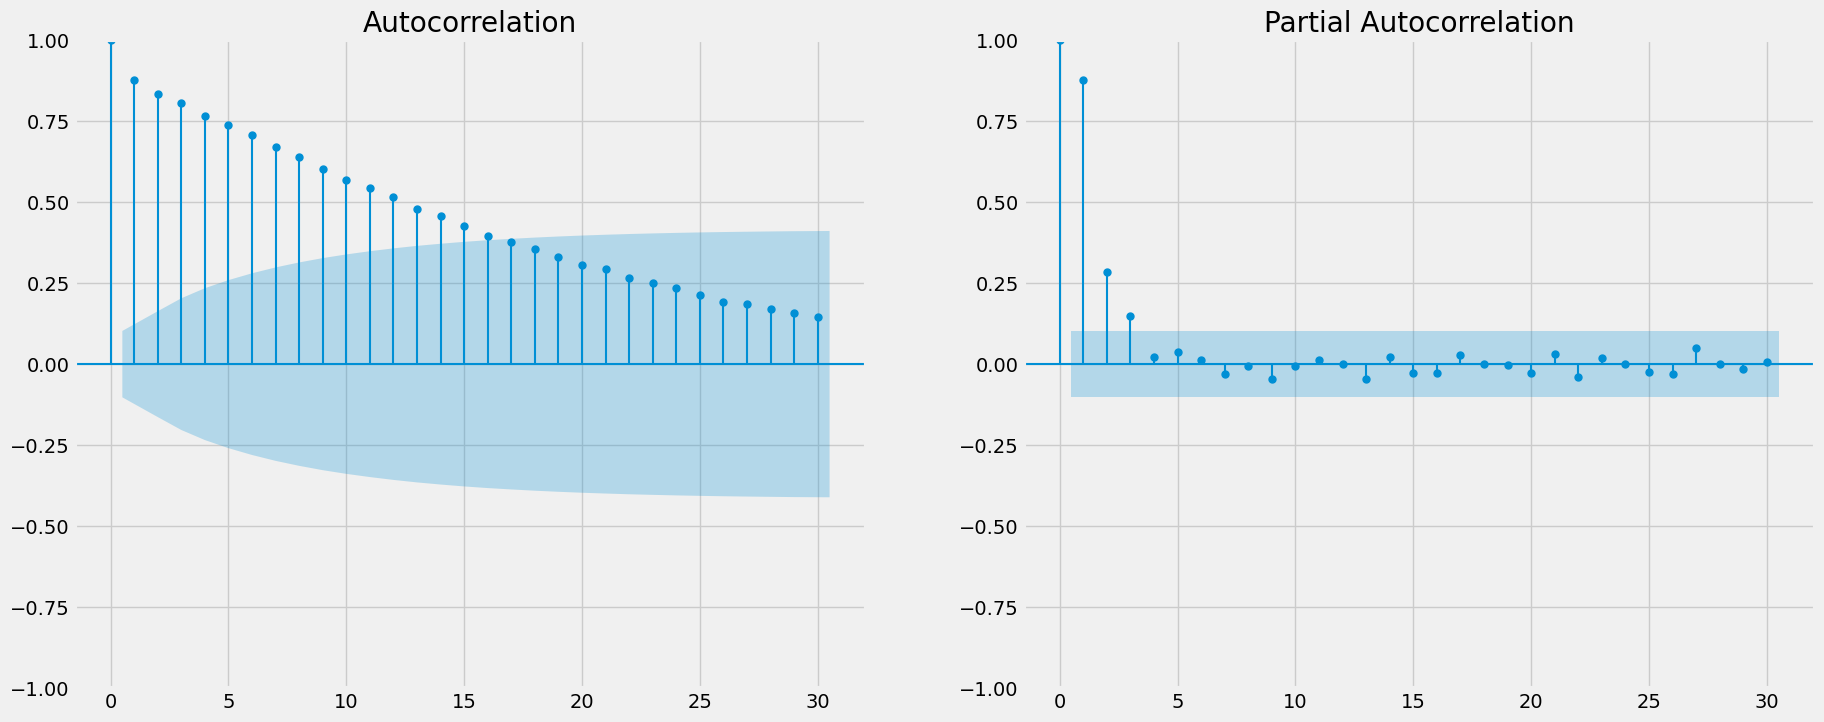

In [21]:
PlotTimeSeries().auto_corr(df=diario.reset_index(), y='qtysold', lags=30)